In [1]:
import matplotlib.cm as cm
from time import time
from matplotlib import lines as mlines
import numpy as np
from jax import random as jran

ran_key = jran.PRNGKey(180)

In [2]:
import os
from astropy.table import Table
diffprof_drn = "/Users/aphearin/work/DATA/diffprof_data"
mdpl2 = Table.read(os.path.join(diffprof_drn, "MDPL2_halo_table.hdf5"))
bpl = Table.read(os.path.join(diffprof_drn, "BPL_halo_table.hdf5"))
print(bpl.keys())

['halo_id', 'conc_beta_early', 'conc_beta_late', 'conc_k', 'conc_lgtc', 'u_conc_beta_early', 'u_conc_beta_late', 'u_conc_k', 'u_conc_lgtc', 'logmp', 'mah_early', 'mah_late', 'mah_logtc', 'mah_k', 'log_mah_fit', 'conch_fit', 'tform_50', 'p_tform_50']


In [3]:
from diffprof.nfw_evolution import lgc_vs_lgt

lgc_vs_lgt_vmap = jjit(jvmap(lgc_vs_lgt, in_axes=(None, 0, 0, 0, 0)))

N_T = 25
TARR_FIT = np.linspace(3.5, 13.8, N_T)

lgconc_history_bpl = np.array(lgc_vs_lgt_vmap(
    np.log10(TARR_FIT), bpl["conc_lgtc"], bpl["conc_k"], bpl["conc_beta_early"], bpl["conc_beta_late"]))
lgconc_history_mdpl2 = np.array(lgc_vs_lgt_vmap(
    np.log10(TARR_FIT), mdpl2["conc_lgtc"], mdpl2["conc_k"], mdpl2["conc_beta_early"], mdpl2["conc_beta_late"]))


In [4]:
from diffprof.get_target_simdata import calculate_halo_sample_target_data

lgmhalo_targets = np.array((12.0, 13.0, 14.0))
p50_targets = np.linspace(0.1, 0.9, 50)

args = (bpl['logmp'], mdpl2['logmp'], lgconc_history_bpl, lgconc_history_mdpl2, 
       bpl['p_tform_50'], mdpl2['p_tform_50'], lgmhalo_targets, p50_targets)

res = calculate_halo_sample_target_data(*args)
lgc_mean_targets_lgm0, lgc_std_targets_lgm0 = res[:2]
lgc_mean_targets_lgm0_p50, lgc_std_targets_lgm0_p50 = res[2:]

In [5]:
from diffprof.dpp_predictions import _get_preds_singlemass
from diffprof.dpp_loss_funcs import _get_grid_data
from diffprof.dpp_opt import get_u_param_grids

n_grid = 2500
grid_key, ran_key = jran.split(ran_key, 2)
u_be_grid, u_lgtc_bl_grid = get_u_param_grids(grid_key, n_grid)

grid_data = _get_grid_data(p50_targets, TARR_FIT, u_be_grid, u_lgtc_bl_grid)

In [6]:
from diffprof.bpl_dpp import DEFAULT_PARAMS
dpp_params = np.array(list(DEFAULT_PARAMS.values()))

In [7]:
from jax import vmap
_m = (None, 0, *[None]*4)
_get_preds_multimass = jjit(vmap(_get_preds_singlemass, in_axes=_m))

_preds = _get_preds_multimass(dpp_params, lgmhalo_targets, TARR_FIT, p50_targets, u_be_grid, u_lgtc_bl_grid)
pred_avg_log_conc_p50, pred_avg_log_conc_lgm0, pred_std_log_conc_lgm0, pred_std_log_conc_p50 = _preds


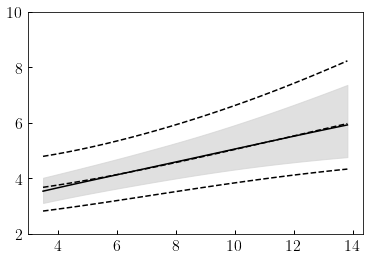

In [8]:
fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(2, 10)

im = 2
__=ax.plot(TARR_FIT, 10**lgc_mean_targets_lgm0[im, :], color='k')
__=ax.plot(TARR_FIT, 10**pred_avg_log_conc_lgm0[im, :], '--', color='k')

lgylo = lgc_mean_targets_lgm0[im, :] - lgc_std_targets_lgm0[im, :]
lgyhi = lgc_mean_targets_lgm0[im, :] + lgc_std_targets_lgm0[im, :]
__=ax.fill_between(TARR_FIT, 10**lgylo, 10**lgyhi, color='lightgray', alpha=0.7)

lgylo = pred_avg_log_conc_lgm0[im, :] - pred_std_log_conc_lgm0[im, :]
lgyhi = pred_avg_log_conc_lgm0[im, :] + pred_std_log_conc_lgm0[im, :]
__=ax.plot(TARR_FIT, 10**lgylo, '--', color='k')
__=ax.plot(TARR_FIT, 10**lgyhi, '--', color='k')


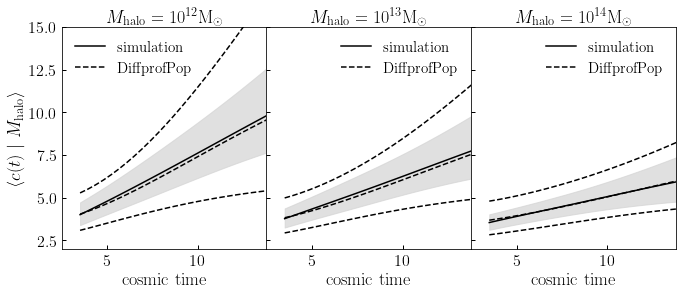

In [9]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11, 4))
(ax0, ax1, ax2) = axes
fig.subplots_adjust(wspace=0, hspace=0)
xlim = ax0.set_xlim(2.5, 13.75)
ylim = ax0.set_ylim(2, 15)

MHALO_LABELS = (r'$M_{\rm halo}=10^{12}{\rm M_{\odot}}$', 
          r'$M_{\rm halo}=10^{13}{\rm M_{\odot}}$',
          r'$M_{\rm halo}=10^{14}{\rm M_{\odot}}$')
for im, ax in enumerate(axes):

    __=ax.plot(TARR_FIT, 10**lgc_mean_targets_lgm0[im, :], color='k', label=r'${\rm simulation}$')
    __=ax.plot(TARR_FIT, 10**pred_avg_log_conc_lgm0[im, :], '--', color='k', label=r'${\rm DiffprofPop}$')

    lgylo = lgc_mean_targets_lgm0[im, :] - lgc_std_targets_lgm0[im, :]
    lgyhi = lgc_mean_targets_lgm0[im, :] + lgc_std_targets_lgm0[im, :]
    __=ax.fill_between(TARR_FIT, 10**lgylo, 10**lgyhi, color='lightgray', alpha=0.7)

    lgylo = pred_avg_log_conc_lgm0[im, :] - pred_std_log_conc_lgm0[im, :]
    lgyhi = pred_avg_log_conc_lgm0[im, :] + pred_std_log_conc_lgm0[im, :]
    __=ax.plot(TARR_FIT, 10**lgylo, '--', color='k')
    __=ax.plot(TARR_FIT, 10**lgyhi, '--', color='k')

    xlabel = ax.set_xlabel(r'${\rm cosmic\ time}$')
    title = ax.set_title(MHALO_LABELS[im])
    leg = ax.legend()
ylabel = ax0.set_ylabel(r'$\langle c(t)\ \vert\ M_{\rm halo}\rangle$')

# title = ax0.set_title(r'$10^{12}{\rm M_{\dot}}$')

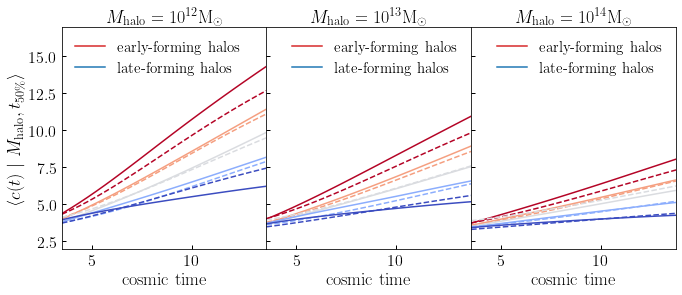

In [10]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11, 4))
(ax0, ax1, ax2) = axes
fig.subplots_adjust(wspace=0, hspace=0)
xlim = ax0.set_xlim(3.5, 13.75)
ylim = ax0.set_ylim(2, 17)

from matplotlib import lines as mlines
red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'${\rm early}$-${\rm forming\ halos}$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'${\rm late}$-${\rm forming\ halos}$')

import matplotlib.cm as cm
from matplotlib import lines as mlines
colormap_seq=np.linspace(1, 0, p50_targets.size)
colors=cm.coolwarm(colormap_seq)

indx_p50_plot = np.searchsorted(p50_targets, np.array([0.1, 0.3, 0.5, 0.7, 0.9]))
p50_plot = p50_targets[indx_p50_plot]

for im, ax in enumerate(axes):
    for ip in indx_p50_plot:
        __=ax.plot(TARR_FIT, 10**lgc_mean_targets_lgm0_p50[im, ip, :], color=colors[ip])
        __=ax.plot(TARR_FIT, 10**pred_avg_log_conc_p50[im, ip, :], '--', color=colors[ip])

    xlabel = ax.set_xlabel(r'${\rm cosmic\ time}$')
    title = ax.set_title(MHALO_LABELS[im])

    leg=ax.legend(handles=[red_line, blue_line])

ylabel = ax0.set_ylabel(r'$\langle c(t)\ \vert\ M_{\rm halo}, t_{50\%}\rangle$')

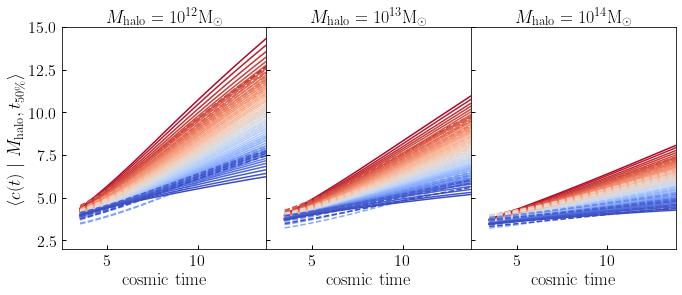

In [11]:
import matplotlib.cm as cm
from matplotlib import lines as mlines

colormap_seq=np.linspace(1, 0, p50_targets.size)
colors=cm.coolwarm(colormap_seq)

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11, 4))
(ax0, ax1, ax2) = axes
fig.subplots_adjust(wspace=0, hspace=0)
xlim = ax0.set_xlim(2.5, 13.75)
ylim = ax0.set_ylim(2, 15)

labels = (r'$M_{\rm halo}=10^{12}{\rm M_{\odot}}$', 
          r'$M_{\rm halo}=10^{13}{\rm M_{\odot}}$',
          r'$M_{\rm halo}=10^{14}{\rm M_{\odot}}$')
for im, ax in enumerate(axes):
    for ip in range(p50_targets.size):
        __=ax.plot(TARR_FIT, 10**lgc_mean_targets_lgm0_p50[im, ip, :], color=colors[ip])
        __=ax.plot(TARR_FIT, 10**pred_avg_log_conc_p50[im, ip, :], '--', color=colors[ip])

    xlabel = ax.set_xlabel(r'${\rm cosmic\ time}$')
    title = ax.set_title(MHALO_LABELS[im])
#     leg = ax.legend()
ylabel = ax0.set_ylabel(r'$\langle c(t)\ \vert\ M_{\rm halo}, t_{50\%}\rangle$')
